In [1]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plot_image_grid import image_grid

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
torch.cuda.is_available()

True

In [3]:
# Setup
# if torch.cuda.is_available():
device = torch.device("cuda:0")
torch.cuda.set_device(device)
# else:
#     device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

In [4]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 50
num_views = 10

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.3, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

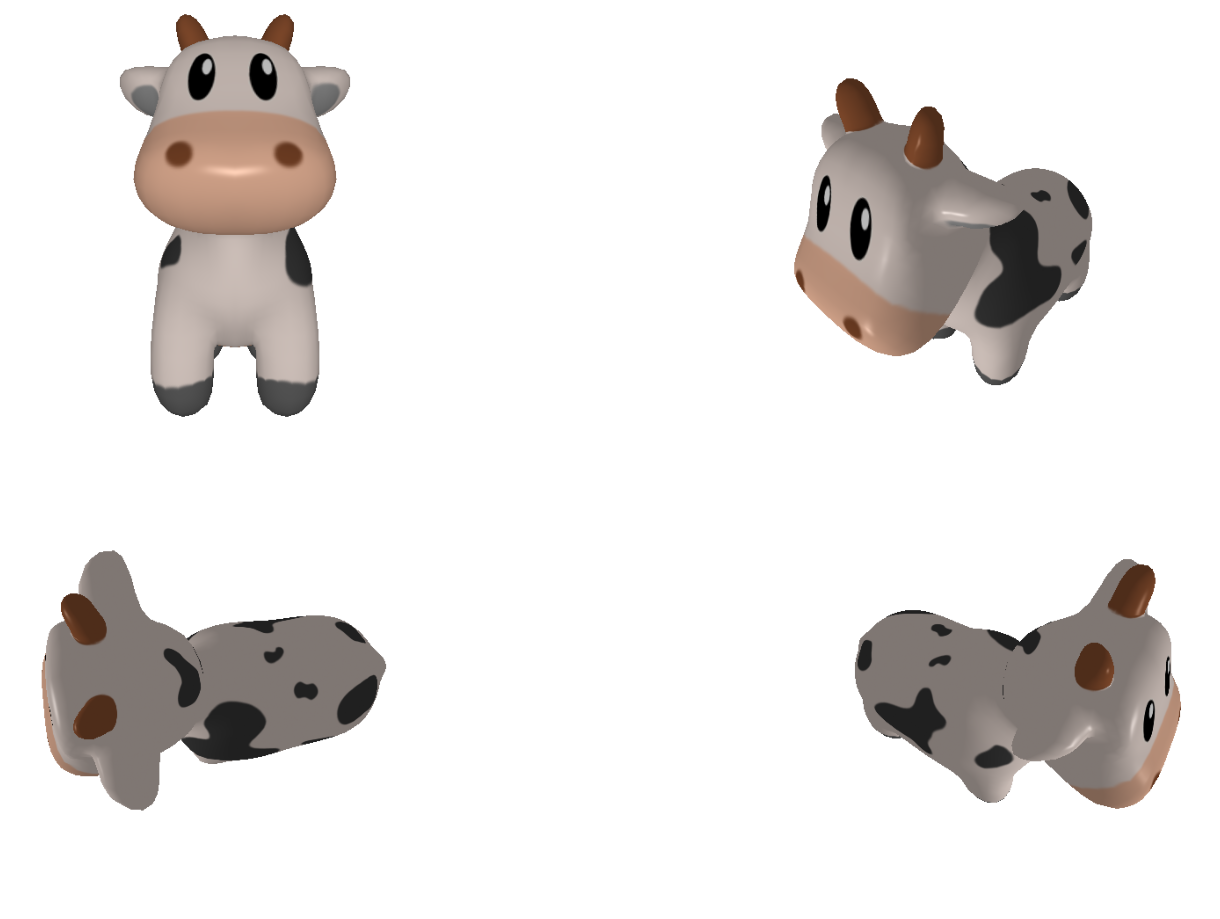

In [5]:
# RGB images
# image_grid(target_images.detach().cpu().numpy(), rows=4, cols=5, rgb=True)
image_grid(target_images.detach().cpu().numpy(), rows=2, cols=2, rgb=True)
plt.show()

In [6]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer, 
                         target_image=target_rgb[1], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

In [7]:
mesh.textures.maps_padded().shape

torch.Size([1, 1024, 1024, 3])

In [8]:
def gaussian_kernel(size, sigma):
    """
    Creates a Gaussian Kernel with the given size and sigma
    """
    # Create a tensor with coordinates of a grid
    x = torch.arange(size).float() - size // 2
    y = torch.arange(size).float() - size // 2
    y, x = torch.meshgrid(y, x)

    # Calculate the gaussian kernel
    gaussian_kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalize the kernel so the sum is 1
    gaussian_kernel /= gaussian_kernel.sum()

    return gaussian_kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

def gaussian_blur(image, kernel_size, sigma):
    """
    Applies Gaussian Blur to the given image using the specified kernel size and sigma
    """
    # Create the kernel
    kernel = gaussian_kernel(kernel_size, sigma).to(image)

    print(kernel.shape)

    # Repeat the kernel for each channel of the image
    kernel = kernel.repeat(image.size(1), 1, 1, 1)

    # Apply padding
    padding = kernel_size // 2

    print(kernel.shape, image.shape)

    # Apply the gaussian kernel, assuming the image is in 'channels first' format
    blurred_image = F.conv2d(image, kernel, padding=padding, groups=image.size(1))

    return blurred_image#.squeeze(0)

In [9]:
from torch.nn import Parameter
import torch.optim as optim
import torch.nn.functional as F

from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesUV

opt_mesh = mesh.clone()
texture_images = opt_mesh.textures.maps_padded()

print(texture_images.permute(0, 3, 1, 2).shape)

kernel_size = 15  # Size of the Gaussian kernel
sigma = 8  # Standard deviation of the Gaussian distribution
blurred_image = gaussian_blur(texture_images.permute(0, 3, 1, 2), kernel_size, sigma).permute(0, 2, 3, 1)

# Convert the texture images to a Parameter for optimization
opt_mesh.textures._maps_padded = Parameter(texture_images)
opt_mesh.textures._maps_padded = Parameter(blurred_image)

optimizer = optim.Adam([opt_mesh.textures.maps_padded()], lr=0.01)

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 1, 15, 15])
torch.Size([3, 1, 15, 15]) torch.Size([1, 3, 1024, 1024])


/home/mcallisterdavid/miniconda3/envs/texture_refinement/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
texture_images.shape, blurred_image.shape

(torch.Size([1, 1024, 1024, 3]), torch.Size([1, 1024, 1024, 3]))

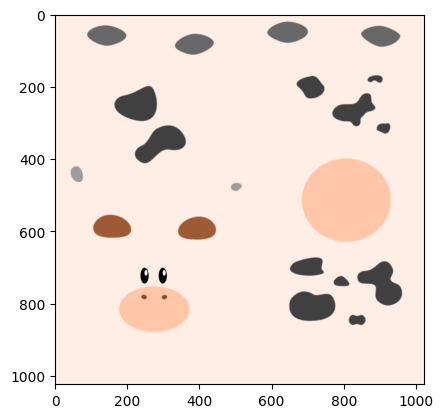

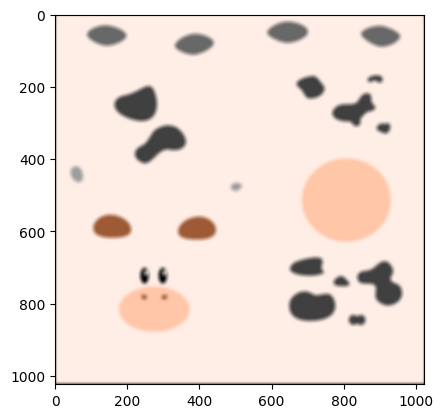

In [11]:
plt.imshow(texture_images.squeeze().cpu())
plt.show()
plt.imshow(blurred_image.squeeze().cpu())
plt.show()

In [12]:
# from pds import PDSConfig, PDS
# from ../pds
import sys
from pathlib import Path

parent_directory = Path().resolve().parent
target_directory = parent_directory / 'pds'

# Add the target directory to sys.path
sys.path.append(str(target_directory))

from pds import PDS, PDSConfig
from utils.imageutil import permute_decoded_latent

pds = PDS(PDSConfig(
    sd_pretrained_model_or_path='stabilityai/stable-diffusion-2-1-base',
    texture_inversion_embedding='../pds/assets/learned_embeds-steps-1500.safetensors'
))

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


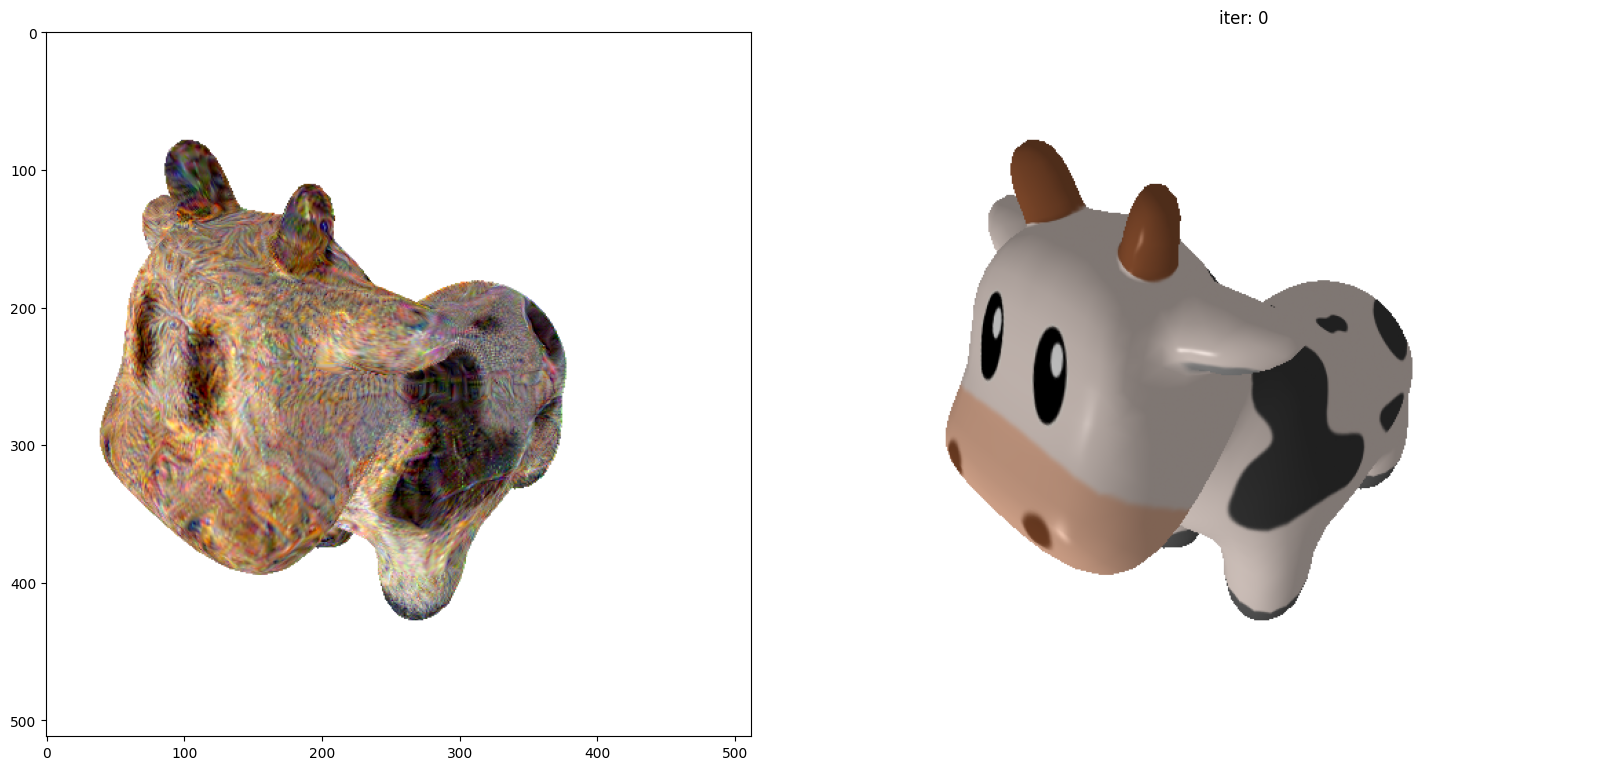

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


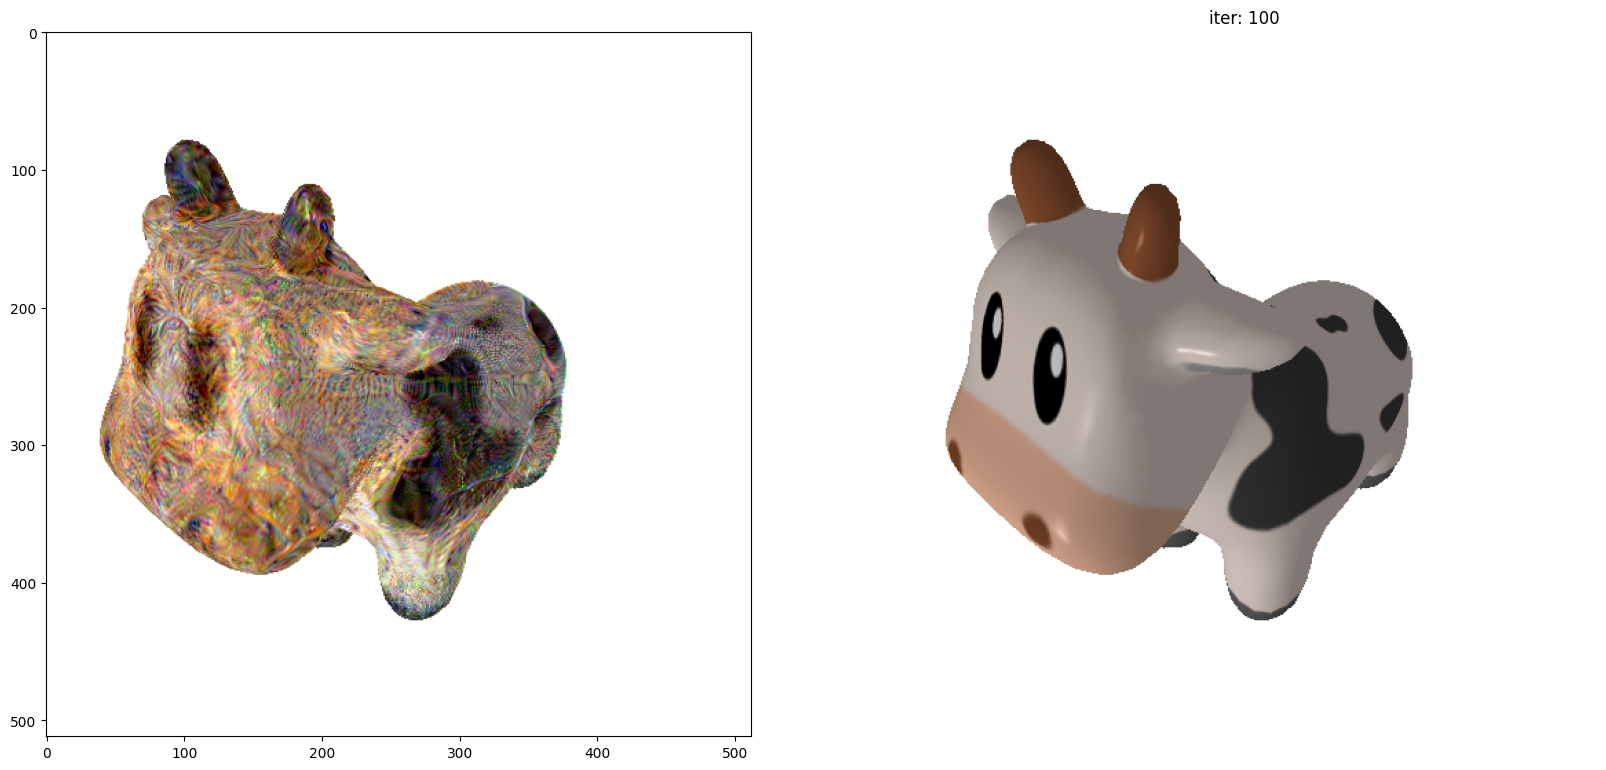

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


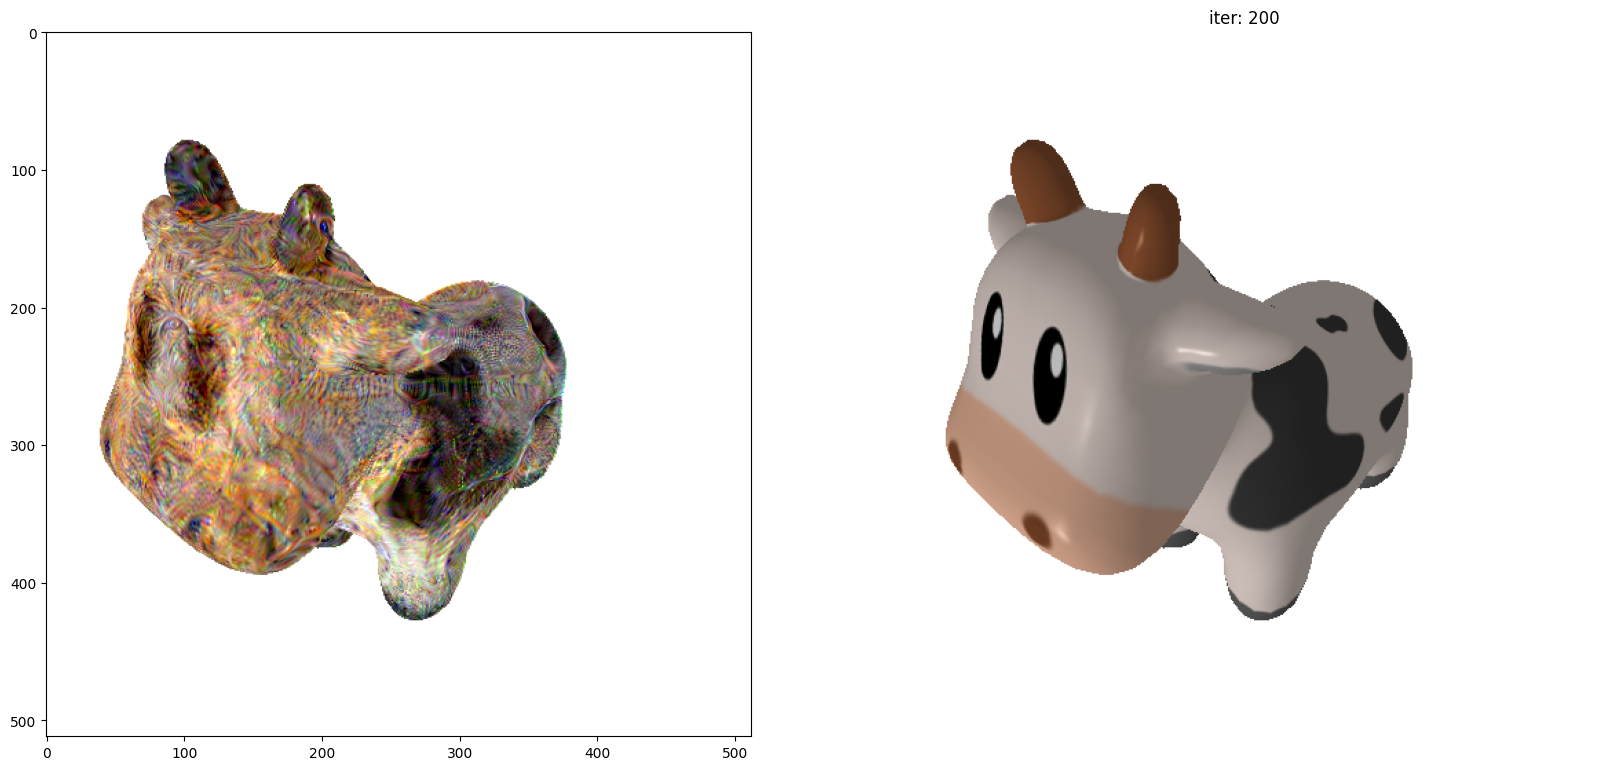

In [14]:
Niter = 2000
plot_period = 100
num_views_per_iteration = 10
loop = tqdm(range(Niter))

losses = {"rgb": {"weight": 1.0, "values": []}}

for i in loop:
    optimizer.zero_grad()
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    
    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        # images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)
        images_predicted = renderer(opt_mesh, cameras=target_cameras[j], lights=lights)
        
        # Squared L2 distance between the predicted RGB image and the target 
        # image from our dataset
        predicted_rgb = images_predicted[..., :3].clamp(0, 1)

        # predicted_rgb = F.interpolate(opt_mesh.textures._maps_padded.permute(0, 3, 1, 2), scale_factor=0.5)
        # loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        # loss_rgb = ((predicted_rgb - torch.ones_like(predicted_rgb)) ** 2).mean()
        # loss["rgb"] += loss_rgb / num_views_per_iteration

        latent_im = pds.encode_image(predicted_rgb.permute(0, 3, 1, 2))
        # latent_im = pds.encode_image(predicted_rgb)

        grad_acc = None

        with torch.no_grad():
            pds_dict = pds.pds_gen(
                im=latent_im,
                t_project = 0.1 * 1,
                # t_edit = 0.5,
                t_edit = torch.rand(1).item() * 0.96 + 0.02,
                prompt="a photo of a cow",
                # extra_src_prompts=', oversaturated, smooth, pixelated, cartoon, foggy, hazy, blurry, bad structure, noisy, malformed',
                extra_src_prompts='. <pds>',
                extra_tgt_prompts=', detailed high resolution, high quality, sharp',
                thresholding=None,
                loss_coefficients=(0, 1),
                # loss_coefficients=(1, 0),
                # eps_loss_use_proj_x0=config.eps_loss_use_proj_x0,
                # src_cfg_scale=config.pds_cfg,
                # tgt_cfg_scale=config.pds_cfg,
                src_method='step',
                return_dict=True
            )
            # if i % plot_period == 0:
            #     decoded = permute_decoded_latent(pds.decode_latent(latent_im)).cpu().numpy()
            #     plt.imshow(decoded)
            #     plt.show()

        grad = pds_dict['grad']
        loss = pds_dict['loss']
        latent_im.backward(gradient=grad, retain_graph=True)

        for param in pds.vae.parameters():
            param.grad = None

        # grad_acc = predicted_rgb.grad if grad_acc is None else grad_acc + 
        # target = pds_dict['target']
        # loss_rgb = ((latent_im - target) ** 2).mean()
        # loss["rgb"] += loss_rgb / num_views_per_iteration


        # im.backward(gradient=grad)
    
    # Weighted sum of the losses
    # sum_loss = torch.tensor(0.0, device=device)
    # for k, l in loss.items():
    #     sum_loss += l * losses[k]["weight"]
    #     losses[k]["values"].append(float(l.detach().cpu()))
    
    # Print the losses
    loop.set_description("total_loss = %.6f" % loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(opt_mesh, renderer=renderer, title="iter: %d" % i, silhouette=False)
        
    # Optimization step
    # sum_loss.backward()
    optimizer.step()

In [10]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False, 
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device, 
        cameras=camera,
        lights=lights)
)